In [1]:
import cv2
import numpy as np
import plotimages

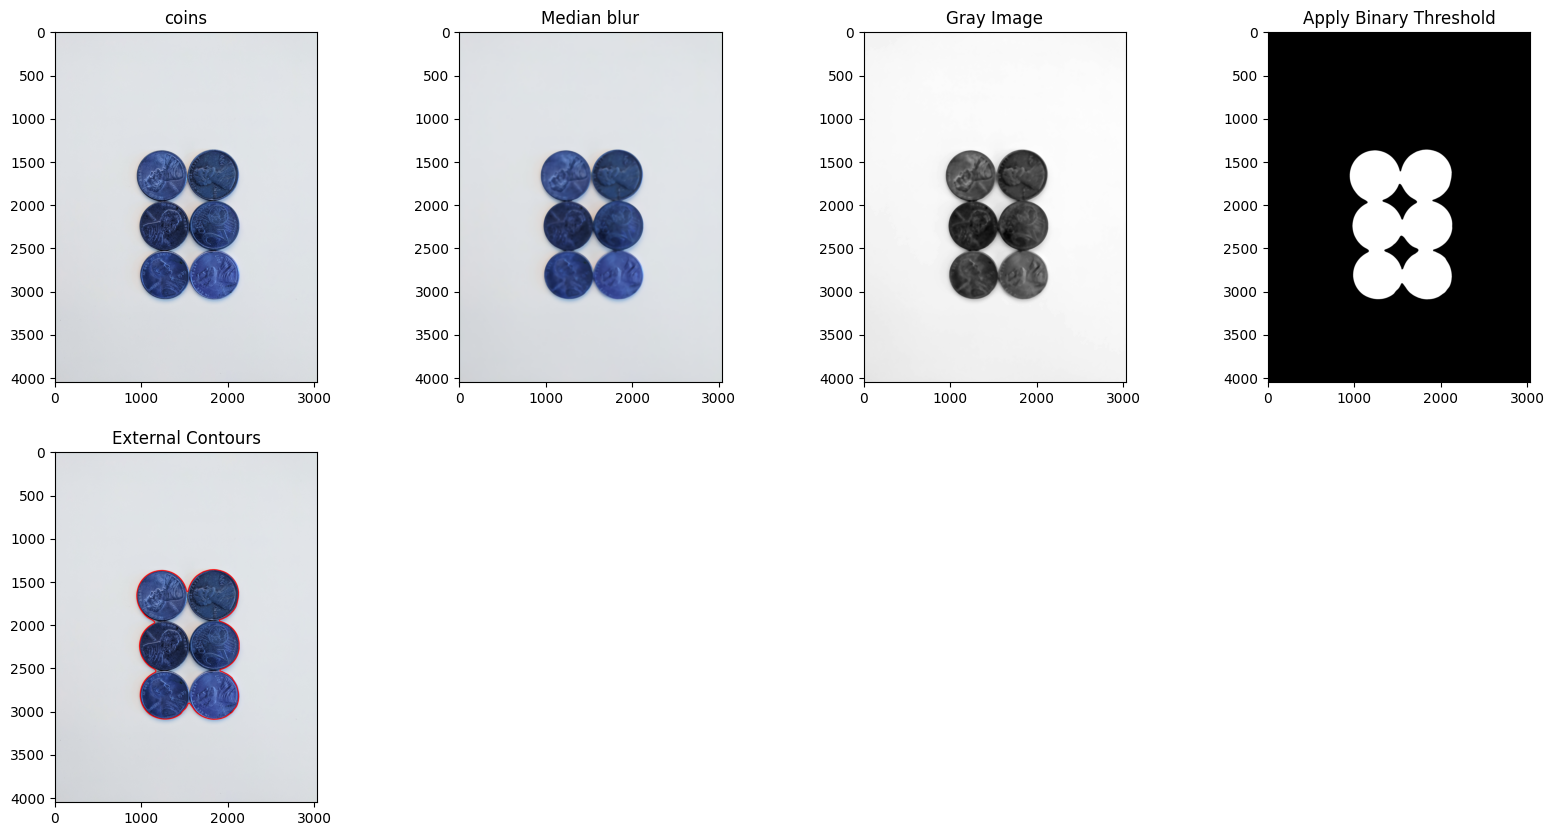

In [15]:
figures = plotimages.plotimages(2,4)

sep_coins = cv2.imread('pennies.jpg')
plotimages.display_img(figures,sep_coins,'coins')

''' 
    Taks : segment the image to seven segments
    Steps:  Median blur, helps us to get rid of features that we do not need
            Grayscale
            Apply a binary threshold to make it white and black
            Find contours
'''

sep_blur = cv2.medianBlur(sep_coins, 25)
plotimages.display_img(figures, sep_blur, 'Median blur')

gray_sep = cv2.cvtColor(sep_blur, cv2.COLOR_BGR2GRAY)
plotimages.display_img(figures, gray_sep, 'Gray Image', 'gray')

ret, sep_thresh = cv2.threshold(gray_sep,160,255,cv2.THRESH_BINARY_INV)
plotimages.display_img(figures, sep_thresh, 'Apply Binary Threshold', 'gray')

contours, hierarchy = cv2.findContours(sep_thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coins,contours,i,(255,0,0),10)
plotimages.display_img(figures, sep_coins, 'External Contours', 'gray')

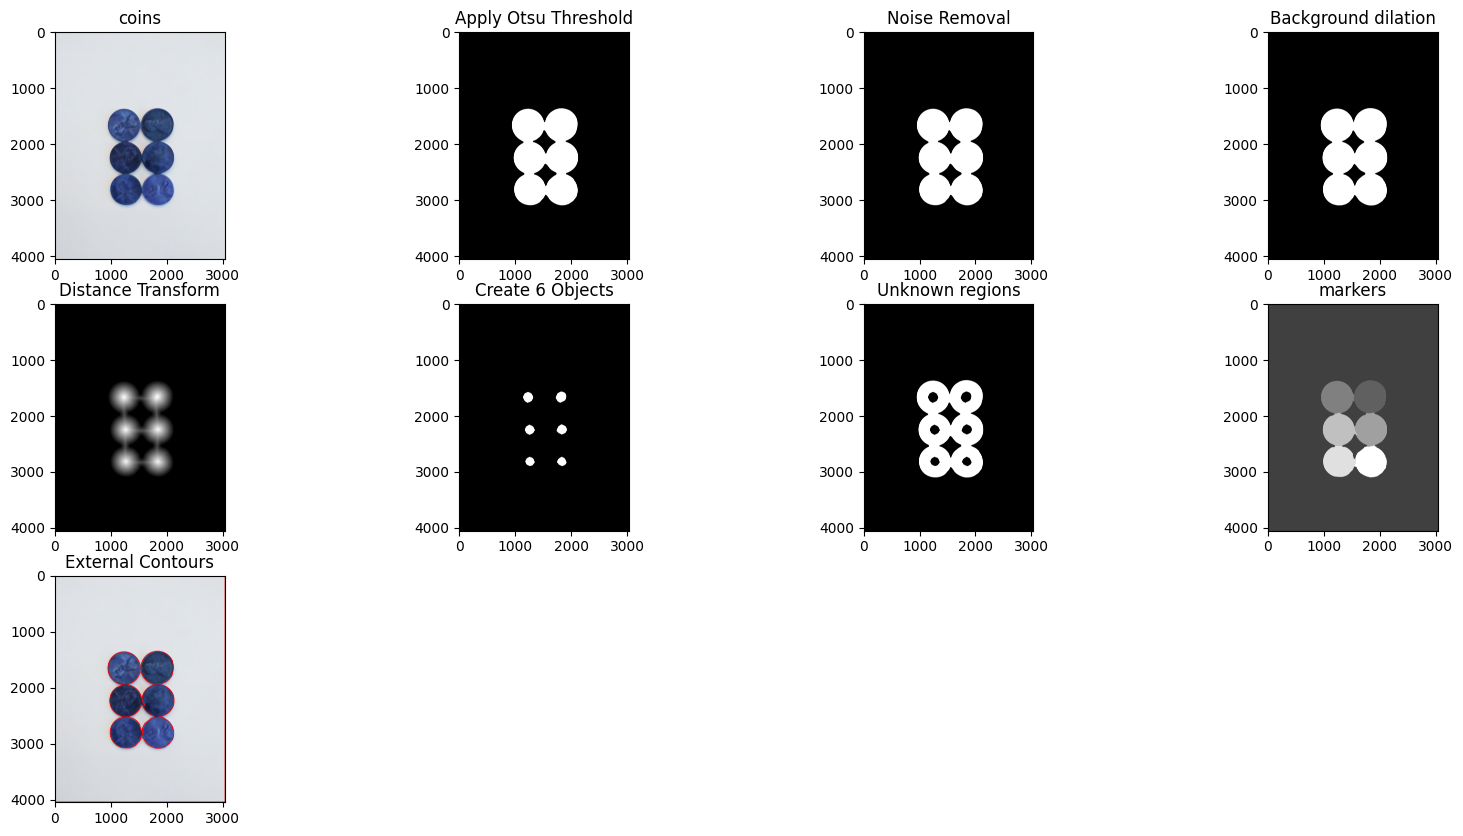

In [29]:
# The above steps can just find external contours and consider as a large buble, So we should use watershed algorithm
figures = plotimages.plotimages(3,4)

sep_coins = cv2.imread('pennies.jpg')
sep_coins = cv2.medianBlur(sep_coins, 35)
plotimages.display_img(figures,sep_coins,'coins')

gray = cv2.cvtColor(sep_coins, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(gray,0,255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plotimages.display_img(figures, thresh, 'Apply Otsu Threshold', 'gray')

# Noise Removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel)
plotimages.display_img(figures, opening, 'Noise Removal', 'gray')

# Use dilation to fing background
sure_bg = cv2.dilate(opening, kernel, iterations=3)
plotimages.display_img(figures, sure_bg, 'Background dilation', 'gray')

# Distance Transform to calculate the distance of object's centers
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,5)
plotimages.display_img(figures, dist_transform, 'Distance Transform', 'gray')

# Create 6 objects in forground
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(),255,0)
plotimages.display_img(figures, sure_fg, 'Create 6 Objects', 'gray')

# figure out unknown regions
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plotimages.display_img(figures, unknown, 'Unknown regions', 'gray')

# Use watershed to mark labels
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==255] = 0
markers = cv2.watershed(sep_coins, markers)
plotimages.display_img(figures, markers, 'markers', 'gray')

contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coins,contours,i,(255,0,0),10)
plotimages.display_img(figures, sep_coins, 'Find Contours', 'gray')